<a href="https://colab.research.google.com/github/royzheng0904/Intro_to_ML/blob/main/comp88_lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COMP0088 Lab Assignment 6



## Introduction

 In general it is rather unlikely that you will want to implement neural network models from scratch, as you did in week 5. Instead you will typically use components provided by a **deep learning framework**. In this week's exercises you will do just that, building several different neural network models using [PyTorch](https://pytorch.org/). These models will also be tested on somewhat more complex data than in previous weeks, doing **image classification** on several standard datasets.

 Depending on the configuration options (which you will probably want to play around with), you are likely to want to use a VM with a GPU for this notebook, rather than the default CPU VM. You can control this using the "Change runtime type" option in the **Connect** popup menu in the upper right of the UI.



## Setting Up

This week's imports are a bit more extensive than usual — in addition to the typical NumPy & Matplotlib libraries we will also need deep learning functionality from PyTorch.

In [1]:
import numpy as np
import numpy.random
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

import torch
from torch import nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor

from time import perf_counter


As usual, fetch the shared COMP0088 lab code from the module GitHub:

In [7]:
# load lab code and resources
!git clone https://github.com/comp0088/shared.git comp0088

# at the moment this is all we care about
import comp0088.utils as utils

Cloning into 'comp0088'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 14 (delta 3), reused 11 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (14/14), 11.54 KiB | 11.54 MiB/s, done.
Resolving deltas: 100% (3/3), done.


Also as usual, set up some basic items for later use.

In [2]:
# set up some items for use in later code
shared_rng = numpy.random.default_rng()

# in practice we will extract this from the data, but
# we'll set up some values here to use as defaults
INPUT_SHAPE = [1, 28, 28]
INPUT_SIZE = np.prod(INPUT_SHAPE)

# default layer configurations for the different model types
DEFAULT_MLP = [32, 32]
DEFAULT_CNN = [16, 16]
DEFAULT_RNN = [64, 1]

NUM_CLASSES = 10
DEFAULT_DATA = 'USPS'

# use CUDA GPU acceleration if it's available
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In addition, we're going to set up a couple more bits of infrastructure for the rest of the assignment.

### Model superclass

First of all, we provide a very simple PyTorch model to act as the base class for the models you'll define in later tasks. This is not just an empty placeholder, it works as a real model, albeit a very simple one. Your own classes will look similar, just a little more complex.

In [3]:
class Model(nn.Module):
    """
    Trivial PyTorch linear model to act as a placeholder
    and parent for the different task classes.
    """

    def __init__(self, input=INPUT_SIZE, output=NUM_CLASSES, create_layers=True):
        """
        Initialise the model.

        The data passed to all the models this week is *image* data.
        Here we flatten it into a vector and apply a single linear
        layer with no activation.

        # Arguments
            input: the input size for the linear layer
            output: the output size for the linear layer
            create_layers: whether to actually create the layers
                -- subclasses will do their own thing instead
        """
        super().__init__()
        self.layers = nn.Sequential( nn.Flatten(), nn.Linear(input, output) ) if create_layers else None

    def forward(self, x):
        """
        Execute a forward pass of the model.

        # Arguments
            x: the input data to the first layer

        # Returns
            output tensor from the last layer
        """
        return self.layers(x)

### Data loading

Training and evaluating image classifiers requires image data. The PyTorch package `torchvision.datasets` provides access to a number of standard image datasets. We define a simple wrapper for that which loads one of the following five datasets:

* [MNIST](http://yann.lecun.com/exdb/mnist/): Classic dataset of 28×28 handwritten digits. Extremely widely used, but also widely considered to be flawed.
* [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist): Dataset of garment images, designed as a drop-in replacement for MNIST that avoids some of its drawbacks.
* [Kuzushiji-MNIST](https://github.com/rois-codh/kmnist): Dataset of 10 handwritten Japanese characters, again intended as a drop-in replacement for MNIST.
* [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html): dataset of small (32×32) colour photographic images of 10 classes (6 types of animal and 4 of vehicle)
* [USPS](https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multiclass.html#usps): Handwritten digit dataset using much smaller (8×8) greyscale images. (We default to this because it is less resource hungry and hence quicker to work with.)

Our wrapper also allows using only a subset of the image classes from the set — so for example you could choose to use only the first 4 digits from MNIST or USPS by specifying `num_classes=4`.

In [4]:
def load_dataset( dataset=DEFAULT_DATA, num_classes=NUM_CLASSES ):
  """
  Load both the training and validation portions of a standard
  image dataset, optionally limiting to only a subset of classes.

  Known datasets are: 'MNIST', 'FashionMNIST', 'Kuzushiji-MNIST',
  'CIFAR10' and 'USPS'. If an unknown dataset is specified we
  default to 'USPS'.

  # Arguments:
    dataset: the name of the dataset to load.
             NB: only the first letter is actually used, case insensitive.
    num_classes: how many of the image classes in the dataset to
             include.

  # Returns:
    train_data: a PyTorch Tensor containing the training data
    val_data: a PyTorch Tensor containing the validation data
    name: the display name of the dataset
    num_classes: the number of classes loaded (this will default
          to 10 if the specified value is out of bounds)

  """
  data, name = {
    'm' : (datasets.MNIST, 'MNIST'),
    'f' : (datasets.FashionMNIST, 'FashionMNIST'),
    'k' : (datasets.KMNIST, 'Kuzushiji-MNIST'),
    'c' : (datasets.CIFAR10, 'CIFAR10'),
  }.get(dataset.lower()[:1], (datasets.USPS, 'USPS'))

  train_data = data('data', train=True, download=True, transform=ToTensor())
  val_data = data('data', train=False, download=True, transform=ToTensor())

  if (num_classes > 1) and (num_classes < NUM_CLASSES):
    train_data = Subset(train_data, np.flatnonzero(np.array(train_data.targets) < num_classes))
    val_data = Subset(val_data, np.flatnonzero(np.array(val_data.targets) < num_classes))
  else:
    num_classes = NUM_CLASSES

  return train_data, val_data, name, num_classes

Let's actually load a dataset and display some random example images from it.

Note that the data loaded here will be used throughout the rest of the notebook unless you explicitly load something different somewhere else. To try out a different dataset just change the name in the `load_dataset` call below and rerun this cell.

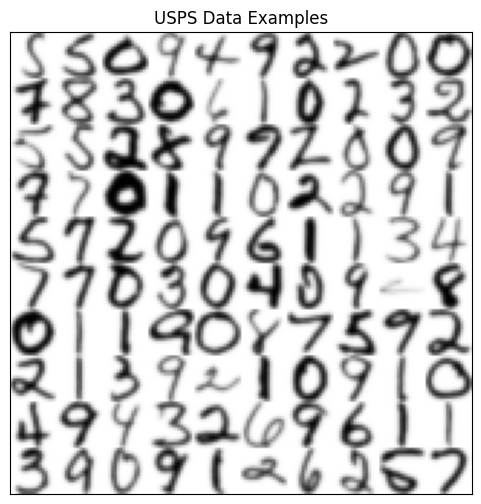

In [8]:
# load image data
train_data, val_data, name, num_classes = load_dataset('USPS')

# plot some samples from the training set
fig = plt.figure(figsize=(6, 6))
ax = fig.subplots()
utils.plot_image(ax, utils.torch_data_to_image_grid(train_data, 10, 10, shuffle=True, rng=shared_rng),
                     title=f'{name} Data Examples')

### Training curves

Finally, we'll provide a simple plotting function to plot the improvement (hopefully) of loss and accuracy over the course of iterative training. There's nothing here you haven't seen before, but we'll be doing the same thing many times so it makes sense to stick it in a function.

In [17]:
def plot_training (train_loss, train_acc, val_loss, val_acc, model_name):
  """
  Plot how loss and accuracy change over training.
  """

  # create a figure & axes to plot into
  fig = plt.figure(figsize=(9, 4.5))
  axs = fig.subplots(nrows=1, ncols=2)

  # choose colours
  blue, orange = plt.cm.tab10.colors[:2]

  # we need to actually have something to plot
  if train_loss[0] is None:
      utils.plot_unimplemented(axs[0], title=f'Loss - {model_name}')
      utils.plot_unimplemented(axs[1], title=f'Accuracy - {model_name}')
  else:
      # x axis for both plots will be the epochs
      epochs = np.arange(1, len(train_loss)+1)

      # plot the losses
      axs[0].plot(epochs, train_loss, color=blue, label='Training')
      axs[0].plot(epochs, val_loss, color=orange, label='Validation')
      axs[0].set_xlabel('Epoch')
      axs[0].set_ylabel('Loss')
      axs[0].set_title(f'Loss - {model_name}')
      axs[0].legend()

      # plot the accuracies
      axs[1].plot(epochs, train_acc, color=blue, label='Training')
      axs[1].plot(epochs, val_acc, color=orange, label='Validation')
      axs[1].set_xlabel('Epoch')
      axs[1].set_ylabel('Accuracy')
      axs[1].set_title(f'Accuracy - {model_name}')
      axs[1].legend()

  fig.tight_layout(pad=1)

# Task 1: Training and Testing

You're going to put together a number of different PyTorch models in this assignment, but the processes of training and testing are essentially the same for all of them, so you'll start by implementing those.

The basic steps for training and testing are the same as in your hand-rolled MLP, and PyTorch will take care of a lot of the underlying fiddliness for you. But as with any framework, you need to get to grips with the classes and functions provided, and the idioms the framework expects you to use.

Both for training a PyTorch model and for testing it, you need to run through the data in mini-batches, processing each in turn. The data will be provided already wrapped in a PyTorch DataLoader object , which you can iterate over directly:

```python
for X, y in dataloader:
	# ... do stuff
```

If you are using an external processor like a GPU, you'll want to make sure that the data batches are copied to it. You should do this by calling `.to(DEVICE)` on the Tensor objects:

```python
	X = X.to(DEVICE)
	y = y.to(DEVICE)
```

(Note: the global variable `DEVICE` here was initialised back in the **Setting Up** section. It's just a string, whose value is either `cuda` or `cpu`. Even if you aren't using a GPU it is sensible to make this call, in case you wind up using one later.)

Many model layers behave differently during training and at test time—for example **dropout** layers only switch neurons off during training. So before invoking a model you should tell it which mode it is in. To set it to training mode call `model.train()`, to set it to evaluation mode call `model.eval()`.

To do a **forward pass** through the model and make predictions, you just invoke it on the data, as if it was a simple function:

```python
preds = model(X)
```

You can then invoke the **loss function** on the predictions:

```python
loss = loss_function(preds, y)
```

As mentioned in lecture 6.4, although PyTorch objects look like functions or data, they are actually proxy objects that participate in operation graphs behind the scenes, potentially on some external compute resource such as a GPU. To actually get at the data you need to call an accessor function, such as `.item()`:

```python
total_loss += loss.item()
```

(You can also convert Tensors to NumPy arrays with `.numpy()`.)

When you call the loss function on the predictions, the loss you get back is a Tensor connected to the end of the operation graph for your model. To perform the **backward pass**, you just call `backward()` on this loss:

```python
loss.backward()
```

This will propagate all the way back through the model, calculating the gradients throughout. Before doing this, you should call `zero_grad()` on the optimiser to start from a clean slate. After the backward pass you tell the optimiser to **update the parameters** by calling `optimiser.step()`.

When evaluating, you don't need the model to calculate gradients because you won't be updating the parameters. You can tell it not to by wrapping it in a `no_grad` context manager:

```python
with torch.no_grad():
	# ... do stuff
```

Training even a single model epoch can take time, so you may want to print progress messages along the way just to reassure yourself that it is doing something.

## 1.1 Train a PyTorch model

Implement the `train_epoch` function in the cell below.

Note that the return values here should be ordinary python numbers, not PyTorch tensors.

In [18]:
def train_epoch(model, dataloader, loss_function, optimiser):
    """
    Train a model on a single epoch of data.

    # Arguments
        model: a pytorch model (an nn.Module subclass, eg our base Model)
        dataloader: a pytorch dataloader that will iterate over the dataset
            in batches
        loss_function: a pytorch loss function tensor
        optimiser: optimiser to use for training

    # Returns
        loss: mean loss over the whole epoch
        accuracy: mean prediction accuracy over the epoch
    """

    t0 = perf_counter()

    # make sure model is in training mode
    model.train()
    size = len(dataloader.dataset)

    # initialise running totals of loss and correct predictions
    total_loss, correct = 0, 0

    # iterate over batches
    # here we use enumerate to get a batch counter as well
    # we could also use `for X,y in dataloader` as described in the notes
    for batch, (X, y) in enumerate(dataloader):

        # make sure the data is on the correct device
        X = X.to(DEVICE)
        y = y.to(DEVICE)

        # run the forward pass
        pred = model(X)

        # compute the loss
        loss = loss_function(pred, y)

        # add this batch's loss & correctness to the running totals
        total_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # run the backward pass
        optimiser.zero_grad()
        loss.backward()

        # update the weights
        optimiser.step()

        # there are potentially a lot of batches, so we don't want
        # to print progress messages too often
        # here we do it every 100
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'loss: {loss:>5f} [{current:>5d}/{size:>5d}, {perf_counter() - t0:.1f}s]')

    # report how long the whole loop took
    print(f'Total time for epoch: {perf_counter()-t0:.2f} seconds')

    # return mean loss and accuracy
    return total_loss/size, correct/size

## 1.2 Evaluate a PyTorch model

Implement the `test_epoch` function in the cell below.

Again, the return values should be numbers, not tensors.

In [19]:
def test_epoch(model, dataloader, loss_function):
    """
    Evaluate a model on a dataset.

    # Arguments
        model: a pytorch model (an nn.Module subclass, eg our base Model)
        dataloader: a pytorch dataloader that will iterate over the dataset
            in batches
        loss_function: a pytorch loss function tensor

    # Returns
        loss: mean loss over the whole epoch
        accuracy: mean prediction accuracy over the epoch
    """

    # record start time so we can report how long it takes
    t0 = perf_counter()

    # switch model to evaluation mode
    model.eval()
    size = len(dataloader.dataset)

    # initialise running totals of loss and correct predictions
    loss, correct = 0, 0

    # tell pytorch not to bother computing gradients
    with torch.no_grad():

        # loop over all the minibatches
        for X, y in dataloader:

            # make sure data is on target device
            X = X.to(DEVICE)
            y = y.to(DEVICE)

            # generate predictions from the data
            pred = model(X)

            # add this batch's loss and correctness to the running totals
            loss += loss_function(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    # compute the means
    loss /= size
    correct /= size
    print(f'\nTest Results: Accuracy: {(100 * correct):>0.1f}%, Mean Loss: {loss:>5f}')
    print(f'Time taken: {perf_counter()-t0:.2f} seconds\n')

    return loss, correct

## 1.3: Perform multi-epoch training

To actually train a model, we'll want to loop over training for many epochs. But we also want to track our progress, so after each epoch of training we'll evaluate the model on our validation set and see how the loss and accuracy change on both sets as we progress. This may allow us to spot overfitting, for example, if the training and validation losses diverge.

Implement the `train_loop` model in the cell below to perform this alternate training and testing over multiple epochs. (You will probably find it helpful to print some outputs as you go so you know your function is actually doing something.)

In [22]:
def train_loop ( model, train_loader, val_loader, loss_function, optimiser, epochs=10 ):
  """
  Train a model for multiple epochs, evaluating on the validation data every step.

  # Arguments
      model: a pytorch model (an nn.Module subclass, eg our base Model)
      train_loader: a pytorch dataloader that will iterate over the training data
      train_loader: a pytorch dataloader that will iterate over the validation data
      loss_function: a pytorch loss function tensor
      optimiser: optimiser to use for training
      epochs: how many epochs to train for

  # Returns
      train_loss: a list of loss values on the training set for each epoch
      train_acc: a list of the accuracies on the training set for each epoch
      val_loss: a list of the loss values on the validation set for each epoch
      val_acc: a list of the accuracies on the validation set for each epoch
  """
  train_loss, train_acc, val_loss, val_acc = [], [], [], []
  for epoch in range(epochs):
    print(f'Epoch {epoch+1}\n-------------------------------')
    loss,acc = train_epoch(model,train_loader,loss_function,optimiser)
    train_loss.append(loss)
    train_acc.append(acc)
    loss,acc = test_epoch(model,val_loader,loss_function)
    val_loss.append(loss)
    val_acc.append(acc)

  return train_loss, train_acc, val_loss, val_acc

## → Run Task 1

Execute the code cell below to use the functions you wrote above to train and evaluate a simple linear model.

As mentioned earlier, we're going to be using the same training process repeatedly in this lab, so it's wrapped in a function here. Note that a number of fitting hyperparameters are specified as function arguments. Feel free to play around with these (here and in later tasks) to get a feel for how they affect performance.

Epoch 1
-------------------------------
loss: 2.277809 [    0/ 7291, 0.0s]
loss: 0.622274 [ 2500/ 7291, 0.3s]
loss: 0.381099 [ 5000/ 7291, 0.6s]
Total time for epoch: 0.89 seconds

Test Results: Accuracy: 87.7%, Mean Loss: 0.020108
Time taken: 0.18 seconds

Epoch 2
-------------------------------
loss: 0.431988 [    0/ 7291, 0.0s]
loss: 0.255450 [ 2500/ 7291, 0.3s]
loss: 0.240497 [ 5000/ 7291, 0.6s]
Total time for epoch: 0.89 seconds

Test Results: Accuracy: 89.2%, Mean Loss: 0.017107
Time taken: 0.18 seconds

Epoch 3
-------------------------------
loss: 0.336780 [    0/ 7291, 0.0s]
loss: 0.176104 [ 2500/ 7291, 0.3s]
loss: 0.195238 [ 5000/ 7291, 0.6s]
Total time for epoch: 0.87 seconds

Test Results: Accuracy: 89.7%, Mean Loss: 0.015969
Time taken: 0.19 seconds

Epoch 4
-------------------------------
loss: 0.294868 [    0/ 7291, 0.0s]
loss: 0.138527 [ 2500/ 7291, 0.3s]
loss: 0.171972 [ 5000/ 7291, 0.6s]
Total time for epoch: 0.88 seconds

Test Results: Accuracy: 90.1%, Mean Loss: 0.0

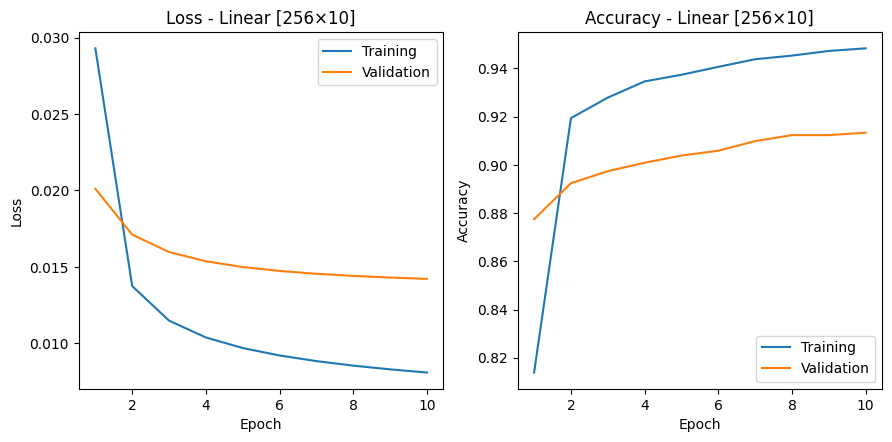

In [23]:
def perform_training ( model, model_name,

                       # data
                       train=train_data, val=val_data,

                       # training configuration
                       batch=25, epochs=10,

                       # optimiser configuration
                       lr=1e-2, decay=0, momentum=0.9 ):
  """
  Train and evaluate a PyTorch model using the provided data, plotting
  results at the end. Uses a standard SGD optimiser and cross entropy loss.

  # Arguments
      model: a PyTorch model (an nn.Module subclass, eg our base Model)
      model_name: display name for the module (used on the final plot)
      train: a PyTorch Tensor of training data, as loaded by `load_dataset`
      val: a PyTorch Tensor of validation data, as loaded by `load_dataset`
      batch: batch size for the mini-batch training
      epochs: number of epochs to train for
      lr: learning rate for the optimiser
      decay: weight decay (L2 regularisation) for the optimiser
      momentum: momentum for the optimiser

  """
  # create data loaders
  train_loader = DataLoader(train, batch_size=batch)
  val_loader = DataLoader(val, batch_size=batch)

  # this is a classification problem, so we'll use a crossentropy loss
  # (NB: by default PyTorch applies softmax squashing to the inputs to this,
  # so there is no need for a separate explicit softmax activation)
  loss_function = nn.CrossEntropyLoss()

  # and a basic gradient descent optimiser
  optimiser = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=decay)

  # train for specified number of epochs
  train_loss, train_acc, val_loss, val_acc = train_loop(model, train_loader, val_loader, loss_function, optimiser, epochs=epochs)

  # finally, let's plot how it went
  plot_training(train_loss, train_acc, val_loss, val_acc, model_name)


# in this case we're just creating a default linear model,
# since you haven't implemented any others yet
input_shape = tuple(train_data[0][0].shape)
input_size = np.prod(input_shape)
model = Model(input=input_size, output=num_classes).to(DEVICE)
model_name = f'Linear [{input_size}×{num_classes}]'

# train it and plot the results
perform_training(model, model_name)


# Task 2: Build a Multi-Layer Perceptron

All of the models in this session are going to have a pretty similar structure: they'll be classes inheriting from the `Model` class defined earlier in **Setting Up** (and in turn from [torch.nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)).

Each will have an `__init__`  method to initialise the layers and a `forward` method to perform the forward pass. (The backward pass will take care of itself through the magic of [automatic differentiation](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html).) However, in this case the `forward` method can be exactly the same as that for `Model`, so you can just inherit that.

The MLP will do essentially the same as what you implemented by hand last week, but built out of PyTorch layers — specifically, [nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) and [nn.ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html). You can wrap these in an [nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) model. As noted in the docstring, you will need to use [nn.Flatten](https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html) to turn the image inputs into simple vectors. (This same process is used in the `Model` class defined earlier, so you may find it helpful to look at that.)

Assign your `Sequential` model to the instance variable `self.layers`, replacing the value set in the superclass, so that `forward` will use it.

In [27]:
class MLP(Model):
    """
    Simple multi-layer perceptron model for image classification.
    """

    def __init__(self, input=INPUT_SIZE, spec=DEFAULT_MLP, output=NUM_CLASSES):
        """
        Initialise the multi-layer perceptron with the specified arrangement
        of fully-connected layers, using ReLU activation on each layer.

        Note that the data passed to this model (as for all models this
        week) will be *image* data, so the first layer in the model
        should be a Flatten layer, to turn the C * W * H pixel arrays
        into one dimensional ones.

        # Arguments
            input: the input size for the first hidden layer
            spec: a list of sizes for the intermediate layers
            output: the output size for the final layer
        """
        super().__init__(input, output, create_layers=False)
        layers = [nn.Flatten()]

        nodes = [input] + spec + [output]

        for ii in range(len(nodes)-1):
          layers +=[nn.Linear(nodes[ii],nodes[ii+1]),nn.ReLU()]
        self.layers = nn.Sequential(*layers)

        # TODO: implement this

## → Run Task 2

Execute the cell below to train and evaluate an MLP model. The hidden layer configuration is specified by `MLP_SPEC` and training hyperparameters are passed as arguments to `perform_training` — you may want to play around with these.

How does the MLP perform? What happens if you repeat the test multiple times? Can it beat the accuracy of the simple linear model? Does it do so consistently?

Epoch 1
-------------------------------
loss: 2.297814 [    0/ 7291, 0.1s]
loss: 1.082333 [ 2500/ 7291, 0.4s]
loss: 0.657505 [ 5000/ 7291, 0.7s]
Total time for epoch: 1.06 seconds

Test Results: Accuracy: 85.2%, Mean Loss: 0.023045
Time taken: 0.19 seconds

Epoch 2
-------------------------------
loss: 0.531393 [    0/ 7291, 0.0s]
loss: 0.137052 [ 2500/ 7291, 0.3s]
loss: 0.231233 [ 5000/ 7291, 0.7s]
Total time for epoch: 0.96 seconds

Test Results: Accuracy: 88.9%, Mean Loss: 0.015745
Time taken: 0.18 seconds

Epoch 3
-------------------------------
loss: 0.225256 [    0/ 7291, 0.0s]
loss: 0.054273 [ 2500/ 7291, 0.4s]
loss: 0.182257 [ 5000/ 7291, 0.7s]
Total time for epoch: 1.09 seconds

Test Results: Accuracy: 90.2%, Mean Loss: 0.014861
Time taken: 0.22 seconds

Epoch 4
-------------------------------
loss: 0.180003 [    0/ 7291, 0.0s]
loss: 0.036654 [ 2500/ 7291, 0.3s]
loss: 0.156734 [ 5000/ 7291, 0.7s]
Total time for epoch: 0.97 seconds

Test Results: Accuracy: 90.4%, Mean Loss: 0.0

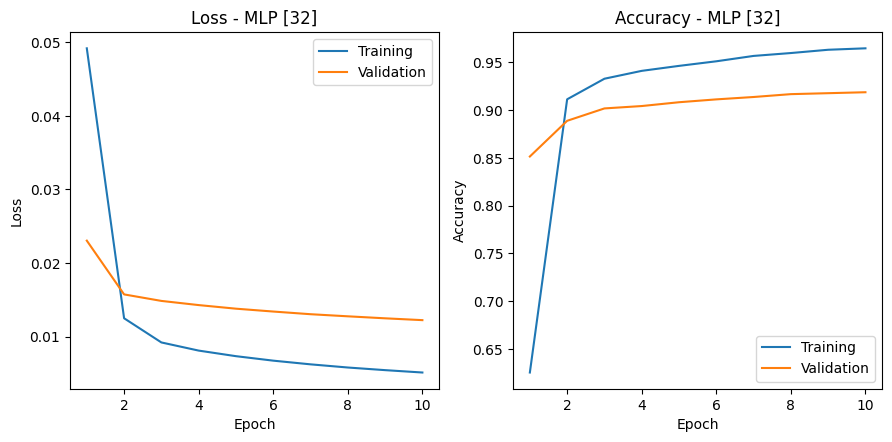

In [28]:
# create an MLP
MLP_SPEC = [32]
input_shape = tuple(train_data[0][0].shape)
input_size = np.prod(input_shape)

model = MLP(input=input_size, spec=MLP_SPEC, output=num_classes).to(DEVICE)
model_name = f'MLP {MLP_SPEC}'

perform_training(model, model_name, batch=25, epochs=10, lr=1e-2, momentum=0.9, decay=0)

# Task 3: Build a Convolutional Neural Network

Convolutional neural networks apply a number of learned *filters* or *convolution kernels* at equally-spaced locations across the data. They are very well-suited to image processing, providing the property of **translational equivariance**: the same patch of pixels will produce the same response wherever it is in the image.

Convolutional layers are defined to match the spatial or temporal dimensionality of the target data: 1D for single stream data like audio, 2D for data with a planar spatial structure like images, 3D for volumetric data, and so on. In this case we will be using image data, so you will need to use 2D layers, which are provided by the PyTorch [nn.Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) class.

CNNs can have pretty complex layer structures, but here we'll keep things simple. All layers will use the same **kernel size**, **padding** and **stride**, and the same (ReLU) activation function. The supplied `spec` argument is just a list defining how many filter channels there are at each layer.

After all the convolutional layers, you'll need to add a final fully-connected (linear) layer to produce the number of class prediction logits specified by `output`. Use the calculation from the lectures to keep track of the output dimensions of the convolutional layers so that you'll know how many outputs there are from the last one. Flatten them and feed the resulting vector into your linear layer. Once again, you should wrap all your layers in a Sequential model.

As in the previous task, you can reuse the superclass implementation of `forward`, so you only need to implement `__init__`. Just remember to assign your model to `self.layers`.


In [31]:
class CNN(Model):
    """
    Simple convolutional neural network model for image classification.
    """

    def __init__(self, input=INPUT_SHAPE, spec=DEFAULT_CNN, output=NUM_CLASSES,
                 kernel=3, stride=2, padding=1):
        """
        Initialise the CNN with the specified arrangement of 2D convolutional
        layers and ReLU activations, with a final fully-connected layer to
        do the classification.

        # Arguments
            input: the input shape for the first convolutional layer
            spec: a list of numbers of channels for the convolutional layers
            output: the output size for the final fully-connected layer
            kernel: kernel size for all layers
            stride: convolution stride for all layers
            padding: amount of padding to add around each layer before convolving
        """
        super().__init__(np.prod(input), output, create_layers=False)
        assert(len(spec) > 0)
        layers = [ nn.Conv2d(input[0], spec[0], kernel_size=kernel, stride=stride, padding=padding), nn.ReLU() ]

        # determine the output dimensions of this first layer
        out_size = int(np.floor(1 + (input[1] + 2 * padding - kernel) / stride))

        # add additional layers according to spec
        for ii in range(len(spec) - 1):
            layers += [ nn.Conv2d(spec[ii], spec[ii+1], kernel_size=kernel, stride=stride, padding=padding), nn.ReLU() ]

            # each time, compute the new output dimension
            out_size = int(np.floor(1 + (out_size + 2 * padding - kernel) / stride))

        # finally, flatten and add a linear mapping from the final output dimension to the required number of classes
        layers += [ nn.Flatten(), nn.Linear(out_size * out_size * spec[-1], output) ]

        # wrap in a Sequential model and assign to layers for use by forward pass
        self.layers = nn.Sequential(*layers)

## → Run Task 3

Execute the cell below to train and evaluate a CNN model. The filter configuration is specified by `CNN_SPEC` and training hyperparameters are again passed as arguments to `perform_training` in case want to play around with them.

How does the CNN perform? What happens if you repeat the test multiple times? Can it beat the accuracy of the simple linear model and/or the MLP? Does it do so consistently?

Epoch 1
-------------------------------
loss: 2.300478 [    0/ 7291, 0.7s]
loss: 0.391347 [ 2500/ 7291, 1.0s]
loss: 0.161479 [ 5000/ 7291, 1.4s]
Total time for epoch: 1.74 seconds

Test Results: Accuracy: 89.3%, Mean Loss: 0.017611
Time taken: 0.22 seconds

Epoch 2
-------------------------------
loss: 0.272893 [    0/ 7291, 0.0s]
loss: 0.050651 [ 2500/ 7291, 0.4s]
loss: 0.193076 [ 5000/ 7291, 0.7s]
Total time for epoch: 1.04 seconds

Test Results: Accuracy: 90.6%, Mean Loss: 0.015466
Time taken: 0.22 seconds

Epoch 3
-------------------------------
loss: 0.181654 [    0/ 7291, 0.0s]
loss: 0.024732 [ 2500/ 7291, 0.3s]
loss: 0.151050 [ 5000/ 7291, 0.7s]
Total time for epoch: 1.02 seconds

Test Results: Accuracy: 91.1%, Mean Loss: 0.014385
Time taken: 0.20 seconds

Epoch 4
-------------------------------
loss: 0.164831 [    0/ 7291, 0.0s]
loss: 0.016338 [ 2500/ 7291, 0.4s]
loss: 0.124853 [ 5000/ 7291, 0.7s]
Total time for epoch: 1.02 seconds

Test Results: Accuracy: 91.5%, Mean Loss: 0.0

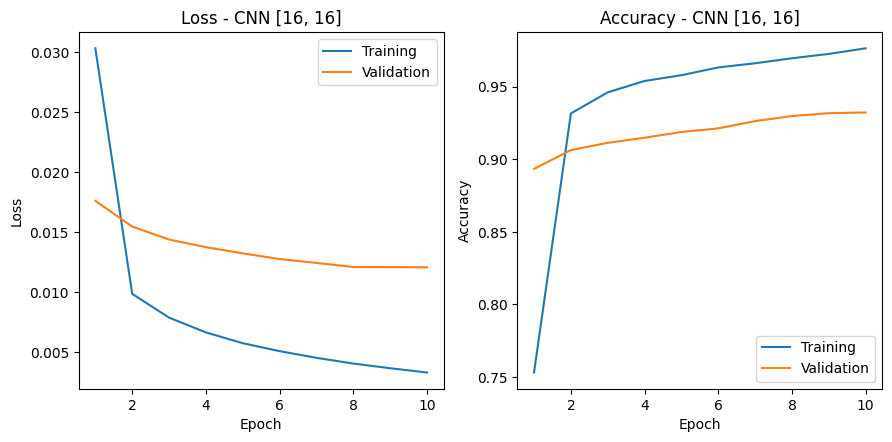

In [32]:
CNN_SPEC = [16,16]
input_shape = tuple(train_data[0][0].shape)

# create the model
model = CNN(input=input_shape, spec=CNN_SPEC, output=num_classes, kernel=3, stride=2, padding=1).to(DEVICE)
model_name = f'CNN {CNN_SPEC}'

# train and evaluate it
perform_training(model, model_name, batch=25, epochs=10, lr=1e-2, momentum=0.9, decay=0)

# Task 4: Implement Recurrent Neural Networks

Recurrent neural networks impose a sequential structure on the data, carrying a memory of earlier processing steps forward through the sequence.

PyTorch includes three standard recurrent layers that you can include in your models: a vanilla recurrent unit ([nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html)), a **long short-term memory** unit ([nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html)) and a **gated recurrent unit** ([nn.GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)). All three have very similar interfaces and can be used interchangeably here. You should choose which kind to create according to the `unit_type` argument.

Image data can be considered as a kind of sequence, eg as a sequence of pixels or a sequence of rows. (Other schemes are also possible if you feel like experimenting.) But the original image data is not in that format, so you will need to **reshape** it in order to match the expected structure, converting each 3D image shape (channels $\times$ height $\times$ width) into a 2D sequence one (steps $\times$ features). If you treat single pixels as tokens, then the sequence length will be the number of pixels in the image; if you treat rows as tokens, then the sequence will be the number of rows.

You'll need to specify the input size (ie, the size of a single sequence token) when you create the recurrent unit, basing it on the supplied `input` argument and your reshaping strategy. You'll then need to do the actual reshaping in your `forward` method, before sending the data to the RNN. (As a result, in this case you can't just fall back on the superclass implementation.) You may also find it helpful to specify `batch_first=True` when creating the unit.

As with the CNN, you'll also need to pass the RNN outputs through a fully connected layer to generate the `output` class logits. Again, there will be some reshaping required here, so in this case it makes sense to have two separate model chunks, rather than trying to pack everything into a Sequential model.


In [33]:
class RNN(Model):
    """
    Simple recurrent network model for image classification.
    """

    def __init__(self, input=INPUT_SHAPE, spec=DEFAULT_RNN, output=NUM_CLASSES,
                 unit_type='lstm'):
        """
        Initialise the RNN with the specified stack of recurrent layers,
        with a final fully-connected layer to do the classification.

        # Arguments
            input: the input shape for the image data.
                we assume [C, H, W] ordering and will convert into
                a sequence ofsequence of H inputs of size C*W
            spec: a list specifying the hidden size of each layer (at element 0)
                and optionally the number of such layers to stack (at element 1)
            output: the output size for the final fully-connected layer
            unit_type: what type of recurrent layers to use
                'lstm': use nn.LSTM
                'gru': use nn.GRU
                (anything else): use nn.RNN
        """
        super().__init__(np.prod(input), output, create_layers=False)
        # here we're going to treat images as a sequence of rows
        # given input of size C x H x W,
        # we'll convert to a sequence H x (W x C)
        self.input_size = input[0] * input[2]   # channels * columns
        self.seq_size = input[1]                # rows

        # hidden size is first part of spec
        self.hidden_size = spec[0]

        # layers is the optional second part
        self.num_layers = spec[1] if len(spec) > 1 else 1

        # we'll convert final hidden state to output size with a linear layer
        self.output = output

        # determine class of layer to create according to unit_type argument
        self.unit_type = unit_type

        cls = {
            'lstm' : nn.LSTM,
            'gru' : nn.GRU,
        }.get(unit_type, nn.RNN)

        # create the recurrent layer and save it as an instance var
        # we specify batch_first because that's how our image inputs will be organised
        self.rnn = cls(input_size=self.input_size, hidden_size=self.hidden_size, num_layers=self.num_layers, batch_first=True)

        # create the fully connected layer and save that as a separate instance var
        self.fc = nn.Linear(self.hidden_size, output)

    def forward(self, X):
        """
        Execute a forward pass of the model.

        # Arguments
            X: the input data tensor to go into the RNN.
               This will be image data with dimension ordering
                 N x C x H x W

        # Returns
            output tensor from the final linear layer
        """
        # TODO: implement this
        #return None

        # --------

        # move channels to end before reshaping, so that rows are
        # in the right place
        X = X.permute(0,2,3,1).reshape(-1, self.seq_size, self.input_size)

        # invoke the RNN
        out, _ = self.rnn(X)

        # out shape: (batch_size, input_size, hidden_size)
        # use the hidden state output from the last step of each sequence
        # as our input to classifier layer
        return self.fc(out[:, -1, :])

## → Run Task 4

Execute the cell below to train and evaluate an RNN model. The hidden state size and number of layers are specified by `RNN_SPEC` and training hyperparameters are again passed as arguments to `perform_training` in case want to play around with them.

How does the RNN perform? What happens if you repeat the test multiple times? Can it beat the accuracy of the other models? Does it do so consistently?

Epoch 1
-------------------------------
loss: 2.286203 [    0/ 7291, 0.2s]
loss: 2.239543 [ 2500/ 7291, 0.6s]
loss: 2.087211 [ 5000/ 7291, 1.0s]
Total time for epoch: 1.35 seconds

Test Results: Accuracy: 33.0%, Mean Loss: 0.071766
Time taken: 0.53 seconds

Epoch 2
-------------------------------
loss: 1.758809 [    0/ 7291, 0.0s]
loss: 1.447419 [ 2500/ 7291, 0.4s]
loss: 0.966972 [ 5000/ 7291, 0.8s]
Total time for epoch: 1.19 seconds

Test Results: Accuracy: 65.9%, Mean Loss: 0.039758
Time taken: 0.20 seconds

Epoch 3
-------------------------------
loss: 0.944829 [    0/ 7291, 0.0s]
loss: 0.681220 [ 2500/ 7291, 0.4s]
loss: 0.403418 [ 5000/ 7291, 0.8s]
Total time for epoch: 1.32 seconds

Test Results: Accuracy: 75.9%, Mean Loss: 0.029151
Time taken: 0.26 seconds

Epoch 4
-------------------------------
loss: 0.642414 [    0/ 7291, 0.0s]
loss: 0.395267 [ 2500/ 7291, 0.5s]
loss: 0.232022 [ 5000/ 7291, 1.1s]
Total time for epoch: 1.50 seconds

Test Results: Accuracy: 82.6%, Mean Loss: 0.0

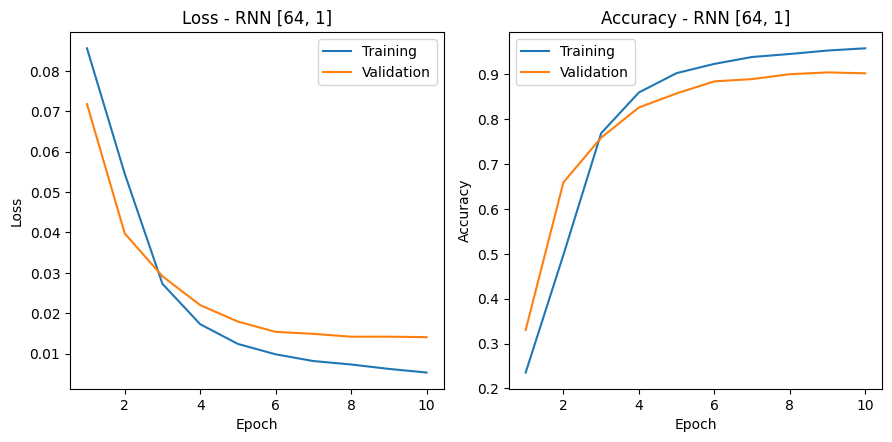

In [34]:
RNN_SPEC = [64,1]
input_shape = tuple(train_data[0][0].shape)

model = RNN(input=input_shape, spec=RNN_SPEC, output=num_classes, unit_type='lstm').to(DEVICE)
model_name = f'RNN {RNN_SPEC}'

perform_training(model, model_name, batch=25, epochs=10, lr=1e-2, momentum=0.9, decay=0)

# Further exploration

The main exploration I'd suggest this week is just trying out different model variations and hyperparameters with the different datasets. Do some consistently perform better than others? Are any of these surprising?

But, if you've exhausted all the basic variations, consider expanding your models to support additional functionality or incorporate new kinds of layers. For example:

* Add **pooling** layers (eg [nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html)) between convolutions in your CNN to collect features over larger regions.
* Allow different filter sizes, strides and padding for each layer in your CNN.
* Add **dropout** layers as a form of regularisation. (Use [nn.Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) for fully connected layers and [nn.Dropout2d](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html) for convolutional layers. For recurrent layers, the layer [constructor](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) includes an argument `dropout` for adding dropout layers internally.)
* The main PyTorch layer types are documented [here](https://pytorch.org/docs/stable/nn.html). Can you think of any other interesting uses for them?

If you're feeling super ambitious, you could try building an **autoencoder** (AE) model using the same image datasets used here for classification. We've only mentioned AEs in passing in the lectures so far — they'll be covered more fully in week 9, but there are no lab exercises that week. The key features you'd need to consider in implementing an AE here are:

* Instead of using the image label from the dataset as the target variable `y`, you should instead use the image data `X` itself. This is what you want the model to learn to reconstruct.
* Your loss function should be something that captures the (dis)similarity of the input and output images. This is more of a regression problem than one of classification, so something like a squared error loss ([nn.MSELoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)) might be appropriate.
* You probably want to make sure that the encoder side of your model steps down to a small code layer that the decoder side then expands. Why? What might you expect to happen without such a bottleneck?